In [4]:
import os

os.system("pip install -r datasets3/src/yolov5/requirements.txt")


1

In [7]:
import json
import os
from tqdm import tqdm
import shutil

train_yolo_save_path = 'results/data/train/'
if not os.path.exists(train_yolo_save_path):
    os.makedirs(train_yolo_save_path)

train_anno_file = "datasets3/mini_airplane/annotations/train.json"
with open(train_anno_file, 'r') as f:
    train_anno = json.load(f)
imageid2annos = dict()
for anno in train_anno["annotations"]:
    imageid = anno["image_id"]
    if imageid not in imageid2annos:
        imageid2annos[imageid] = []
    imageid2annos[imageid].append(anno)
    
for image in tqdm(train_anno["images"]):
    imageid = image["id"]
    imagename = image["file_name"]
    image_h = image["height"]
    image_w = image["width"]
    dh = 1 / image_h
    dw = 1 / image_w
    with open(train_yolo_save_path + imagename.split(".")[0] + ".txt", "w") as f:
        for anno in imageid2annos[imageid]:
            xmin, ymin, w, h = anno["bbox"]
            xmax = xmin + w
            ymax = ymin + h
            x_center = (xmin + xmax) / 2.0
            x_center = x_center * dw
            y_center = (ymin + ymax) / 2.0
            y_center = y_center * dh
            w *= dw
            h *= dh
            mystring = "0" + " " + str(round(x_center,7)) + " " +  str(round(y_center,7)) + " " +  str(round(w,7)) + " " +  str(round(h,7))
            f.write(mystring)
            f.write("\n")
    shutil.copy("datasets3/mini_airplane/images/" + imagename, train_yolo_save_path + imagename)

100%|██████████| 79/79 [00:00<00:00, 553.78it/s]


In [8]:
val_yolo_save_path = 'results/data/val/'
if not os.path.exists(val_yolo_save_path):
    os.makedirs(val_yolo_save_path)
val_anno_file = "datasets3/mini_airplane/annotations/val.json"
with open(val_anno_file, 'r') as f:
    val_anno = json.load(f)
imageid2annos = dict()
for anno in val_anno["annotations"]:
    imageid = anno["image_id"]
    if imageid not in imageid2annos:
        imageid2annos[imageid] = []
    imageid2annos[imageid].append(anno)
    
for image in tqdm(val_anno["images"]):
    imageid = image["id"]
    imagename = image["file_name"]
    image_h = image["height"]
    image_w = image["width"]
    dh = 1 / image_h
    dw = 1 / image_w
    with open(val_yolo_save_path + imagename.split(".")[0] + ".txt", "w") as f:
        for anno in imageid2annos[imageid]:
            xmin, ymin, w, h = anno["bbox"]
            xmax = xmin + w
            ymax = ymin + h
            x_center = (xmin + xmax) / 2.0
            x_center = x_center * dw
            y_center = (ymin + ymax) / 2.0
            y_center = y_center * dh
            w *= dw
            h *= dh
            mystring = "0" + " " + str(round(x_center,7)) + " " +  str(round(y_center,7)) + " " +  str(round(w,7)) + " " +  str(round(h,7))
            f.write(mystring)
            f.write("\n")
    shutil.copy("datasets3/mini_airplane/images/" + imagename, val_yolo_save_path + imagename)

100%|██████████| 20/20 [00:00<00:00, 551.74it/s]


In [9]:
import os

os.system("ls results/data/val/")


1

In [10]:
with open("results/data/val/COCO_val2014_000000179142.txt", "r") as f:
    content = f.read()
    print(content)


0 0.4929759 0.4304922 0.9043326 0.2242031



In [12]:
with open("datasets3/src/yolov5/data/mini-airplane.yaml", "r") as f:
    content = f.read()
    print(content)


# COCO 2017 dataset http://cocodataset.org - first 128 training images
# Download command:  python -c "from yolov5.utils.google_utils import gdrive_download; gdrive_download('1n_oKgR81BJtqk75b00eAjdv03qVCQn2f','coco128.zip')"
# Train command: python train.py --data ./data/coco128.yaml
# Dataset should be placed next to yolov5 folder:
#   /parent_folder
#     /mini-airplane
#     /yolov5


# train and val datasets (image directory or *.txt file with image paths)
train: results/data/train/
val: results/data/val/

# number of classes
nc: 1

# class names
names: ['airplane']



In [14]:
with open("datasets3/src/yolov5/models/yolov5s-airplane.yaml", "r") as f:
    content = f.read()
    print(content)


# parameters
nc: 1  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [116,90, 156,198, 373,326]  # P5/32
  - [30,61, 62,45, 59,119]  # P4/16
  - [10,13, 16,30, 33,23]  # P3/8

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]], # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
  ]

# YOLOv5 head
head:
  [[-1, 3, BottleneckCSP, [1024, False]],  # 9

   [-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1

In [15]:
import os

os.system("python datasets3/src/yolov5/train.py --img 640 --batch 2 --epochs 5 --data datasets/src/yolov5/data/mini-airplane.yaml --cfg datasets/src/yolov5/models/yolov5s-airplane.yaml --weights datasets/src/yolov5/yolov5s.pt")


1

In [35]:
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import glob
import numpy as np

%matplotlib inline

In [36]:
with open("datasets3/results/results.txt", "r") as f:
    content = f.read()
    print(content)


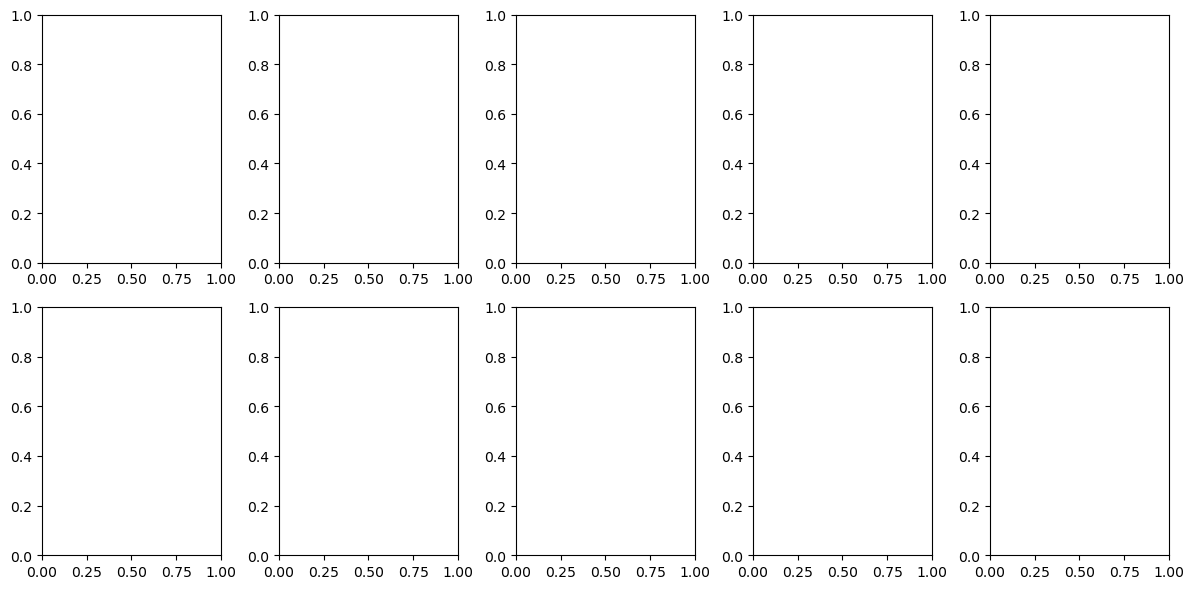

In [37]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

def plot_results(start=0, stop=0, bucket='', id=(), labels=()):  
    # 绘制训练结果log图 'results/results.txt' 
    fig, ax = plt.subplots(2, 5, figsize=(12, 6))
    ax = ax.ravel()
    s = ['GIoU', 'Objectness', 'Classification', 'Precision', 'Recall',
         'val GIoU', 'val Objectness', 'val Classification', 'mAP@0.5', 'mAP@0.5:0.95']
    
    if bucket:
        os.system('rm -rf storage.googleapis.com')
        files = ['https://storage.googleapis.com/%s/results%g.txt' % (bucket, x) for x in id]
    else:
        files = glob.glob('results/results*.txt') + glob.glob('../../Downloads/results*.txt')
    
    for fi, f in enumerate(files):
        try:
            results = np.loadtxt(f, usecols=[2, 3, 4, 8, 9, 12, 13, 14, 10, 11], ndmin=2).T
            n = results.shape[1]  # number of rows
            x = range(start, min(stop, n) if stop else n)
            for i in range(10):
                y = results[i, x]
                if i in [0, 1, 2, 5, 6, 7]:
                    y[y == 0] = np.nan  # dont show zero loss values
                    # y /= y[0]  # normalize
                label = labels[fi] if len(labels) > fi else Path(f).stem
                ax[i].plot(x, y, marker='.', label=label, linewidth=2, markersize=8)
                ax[i].set_title(s[i])
                ax[i].legend()  # Ensure legend is created for each subplot
                # if i in [5, 6, 7]:  # share train and val loss y axes
                #     ax[i].get_shared_y_axes().join(ax[i], ax[i - 5])
        except Exception as e:
            print(f'Warning: Plotting error for {f}, skipping file. Error: {e}')
    
    fig.tight_layout()
    fig.savefig('datasets3/results/results.png', dpi=200)

labels = ['GIoU', 'Objectness', 'Classification', 'Precision', 'Recall',
         'val GIoU', 'val Objectness', 'val Classification', 'mAP@0.5', 'mAP@0.5:0.95']
plot_results(labels=labels)

In [38]:
img = mpimg.imread('results/train_batch0.jpg')
plt.imshow(img)
plt.axis('off')

FileNotFoundError: [Errno 2] No such file or directory: 'results/train_batch0.jpg'

In [39]:
import os

source = "results/data/train"
weights = "models/best.pt"
conf = 0.4

os.system(f"python datasets/src/yolov5/detect.py --source {source} --weights {weights} --conf {conf}")


2

In [41]:
from glob import glob
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
for img in glob("results/inference/output/" + "*.jpg"):
    input_img = cv2.imread(img)
    plt.imshow(cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB))
    plt.show()